In [118]:
from functools import partial

import distrax
import haiku as hk
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from jax import numpy as jnp
from jax import random
from jax import scipy as jsp
from surjectors import Chain, MaskedCoupling, TransformedDistribution
from surjectors.conditioners import mlp_conditioner
from surjectors.util import make_alternating_binary_mask

from sbi import SNL
from sbi.mcmc import sample_with_nuts

In [ ]:
def likelihood(theta):
    theta = jnp.tile(theta, [y.shape[0], 1])
    return part(x=theta)


def likelihood_fn(y, theta):
    y = y[:, : config.ndim_data]
    mu = jnp.repeat(theta[:2], 4)
    corr = theta[2] * theta[3] * jnp.tanh(theta[4])
    cov = jnp.array([[theta[2] ** 2, corr], [corr, theta[3] ** 2]])
    cov = jsp.linalg.block_diag(*[cov for _ in range(4)])
    p = distrax.MultivariateNormalFullCovariance(mu, cov)
    lp = p.log_prob(y)
    return lp


def likelihood(theta):
    return part(theta=theta)


def _log_prob_fn(theta):
    prior = distrax.Uniform(low=-3, high=3).log_prob(theta)
    lp = likelihood(theta)


return jnp.sum(lp) + jnp.sum(prior)

In [468]:
def prior_fns():
    p = distrax.Uniform(jnp.full(5, -3.0), jnp.full(5, 3.0))
    return p.sample, p.log_prob


def likelihood_fn(theta, y):
    mu = jnp.tile(theta[:2], 4)
    s1, s2 = theta[2] ** 2, theta[3] ** 2
    corr = s1 * s2 * jnp.tanh(theta[4])
    cov = jnp.array([[s1**2, corr], [corr, s2**2]])
    cov = jsp.linalg.block_diag(*[cov for _ in range(4)])
    p = distrax.MultivariateNormalFullCovariance(mu, cov)
    return p.log_prob(y)


def _sample(seed, theta):
    mu = jnp.tile(theta[:2], 4)
    s1, s2 = theta[2] ** 2, theta[3] ** 2
    corr = s1 * s2 * jnp.tanh(theta[4])
    cov = jnp.array([[s1**2, corr], [corr, s2**2]]).T
    cov = jsp.linalg.block_diag(*[cov for _ in range(4)])
    p = distrax.MultivariateNormalFullCovariance(mu, cov)
    return p.sample(seed=seed)


def simulator(seed, thetas):
    def _unpack_params(ps):
        m0 = ps[:, [0]]
        m1 = ps[:, [1]]
        s0 = ps[:, [2]] ** 2
        s1 = ps[:, [3]] ** 2
        r = np.tanh(ps[:, [4]])
        return m0, m1, s0, s1, r

    m0, m1, s0, s1, r = _unpack_params(thetas)
    us = distrax.Normal(0.0, 1.0).sample(
        seed=seed, sample_shape=(thetas.shape[0], 4, 2)
    )
    xs = jnp.empty_like(us)

    xs = xs.at[:, :, 0].set(s0 * us[:, :, 0] + m0)
    xs = xs.at[:, :, 1].set(
        s1 * (r * us[:, :, 0] + np.sqrt(1.0 - r**2) * us[:, :, 1]) + m1
    )

    return xs.reshape(-1, 8), us

In [470]:
_sample(random.PRNGKey(1), jnp.squeeze(thetas))

Array([-1.5329541, -2.0472488, -2.247376 , -2.397005 ,  0.2845434,
       -3.5391295, -2.697091 , -4.4537706], dtype=float32)

In [471]:
y, us = simulator(random.PRNGKey(1), thetas)
y

Array([[-1.5329541, -2.0472488, -2.247376 , -2.397005 ,  0.2845434,
        -3.5391295, -2.697091 , -4.4537706]], dtype=float32)

In [472]:
prior_sampler, prior_fn = prior_fns()

In [473]:
# thetas = prior_sampler(seed=random.PRNGKey(123))
# y_observed = simulator(seed=random.PRNGKey(123), thetas=jnp.atleast_2d(thetas))
thetas = jnp.array([-0.7, -2.9, -1.0, -0.9, 0.6])
y_observed = jnp.array(
    [
        [
            -0.9707123,
            -2.9461224,
            -0.4494722,
            -3.4231849,
            -0.13285634,
            -3.364017,
            -0.85367596,
            -2.4271638,
        ]
    ]
)

In [474]:
def log_density_fn(theta, y):
    prior_lp = prior_fn(theta)
    likelihood_lp = likelihood_fn(theta, y)

    lp = jnp.sum(prior_lp) + jnp.sum(likelihood_lp)
    return lp


log_density_partial = partial(log_density_fn, y=y_observed)
log_density = lambda x: log_density_partial(**x)

In [475]:
rng_seq = hk.PRNGSequence(12)
len_theta = 5
nuts_samples = sample_with_nuts(
    rng_seq, log_density, len_theta, 20, 50000, 10000
)
nuts_samples = nuts_samples.reshape(-1, len_theta)

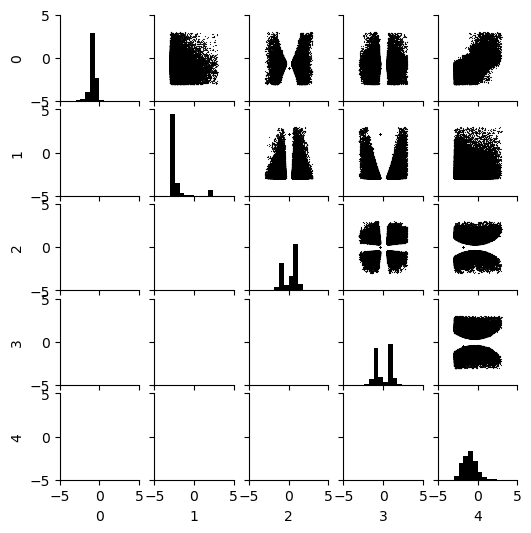

In [480]:
g = sns.PairGrid(pd.DataFrame(nuts_samples))
g.map_upper(sns.scatterplot, color="black", marker=".", edgecolor=None, s=2)
g.map_diag(plt.hist, color="black")
for ax in g.axes.flatten():
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
g.fig.set_figheight(5)
g.fig.set_figwidth(5)
plt.show()

In [400]:
import numpyro
from numpyro import distributions as dist
from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis, SliceSampler
from numpyro.infer import MCMC, NUTS

In [409]:
def model(y):
    theta = numpyro.sample(
        "theta", dist.Uniform(jnp.full(5, -3.0), jnp.full(5, 3.0))
    )
    mu = jnp.repeat(theta[:2], 4)
    s1 = theta[2] ** 2
    s2 = theta[3] ** 2
    corr = s1 * s2 * jnp.tanh(theta[4])
    cov = jnp.array([[s1**2, corr], [corr, s2**2]])
    cov = jsp.linalg.block_diag(*[cov for _ in range(4)])
    numpyro.sample(
        "y", dist.MultivariateNormal(loc=mu, covariance_matrix=cov), obs=y
    )

In [410]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=10000, num_samples=30000, num_chains=20)
sams = mcmc.run(random.PRNGKey(2), y_observed)
mcmc.print_summary()

/var/folders/w8/7mc8k9m916qgh982xqxfgsr00000gn/T/ipykernel_71695/3465268423.py:2: UserWarning: There are not enough devices to run parallel chains: expected 20 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(20)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|█████████████████████████████████████| 40000/40000 [00:17<00:00, 2323.27it/s, 15 steps of size 6.39e-02. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]     -1.78      0.49     -1.82     -2.57     -1.08  70846.65      1.00
  theta[1]     -1.53      0.48     -1.57     -2.29     -0.82  70669.28      1.00
  theta[2]     -0.12      1.21     -0.84     -1.59      1.53     10.68      3.93
  theta[3]      0.52      1.26      1.10     -1.61      1.88     10.81      3.65
  theta[4]     -2.02      0.89     -2.28     -3.00     -0.83  25133.50      1.00

Number of divergences: 53599


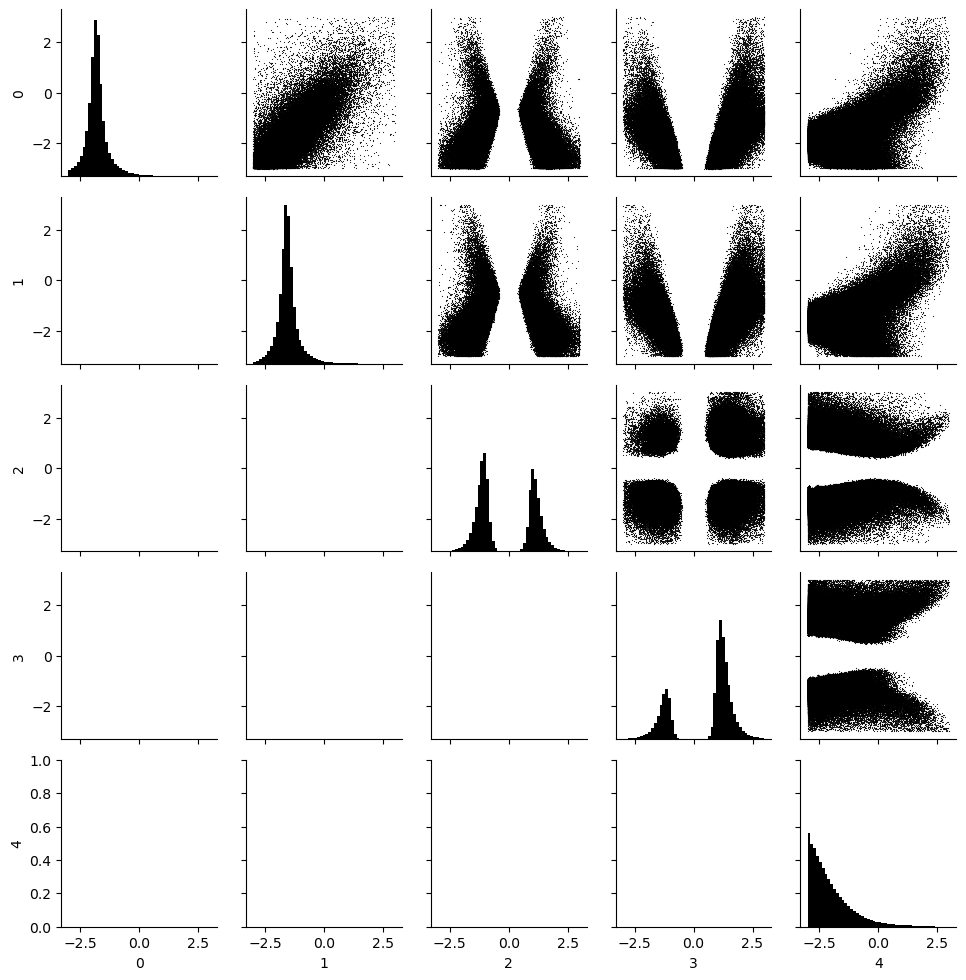

In [411]:
g = sns.PairGrid(pd.DataFrame(mcmc.get_samples()["theta"]), height=2)
g.map_upper(sns.scatterplot, color="black", marker=".", edgecolor=None, s=2)
g.map_diag(plt.hist, color="black", bins=50)
plt.show()

In [ ]:
fns = (prior_sampler, prior_fn), simulator

snl = SNL(fns, make_model(2))
optimizer = optax.adam(1e-3)
params, info = snl.fit(random.PRNGKey(23), y_observed, optimizer)

nuts_samples = sample_with_nuts(rng_seq, log_density, 2, 4, 2000, 1000)
snl_samples, _ = snl.sample_posterior(params, 4, 10000, 7500)

snl_samples = snl_samples.reshape(-1, 2)
nuts_samples = nuts_samples.reshape(-1, 2)

In [69]:
def make_model(dim):
    def _bijector_fn(params):
        means, log_scales = jnp.split(params, 2, -1)
        return distrax.ScalarAffine(means, jnp.exp(log_scales))

    def _flow(method, **kwargs):
        layers = []
        for i in range(2):
            mask = make_alternating_binary_mask(dim, i % 2 == 0)
            layer = MaskedCoupling(
                mask=mask,
                bijector=_bijector_fn,
                conditioner=mlp_conditioner([8, 8, dim * 2]),
            )
            layers.append(layer)
        chain = Chain(layers)

        base_distribution = distrax.Independent(
            distrax.Normal(jnp.zeros(dim), jnp.ones(dim)),
            reinterpreted_batch_ndims=1,
        )
        td = TransformedDistribution(base_distribution, chain)
        return td(method, **kwargs)

    td = hk.transform(_flow)
    td = hk.without_apply_rng(td)
    return td

In [ ]:
rng_seq = hk.PRNGSequence(0)
y_observed = jnp.array([-1.0, 1.0])

log_density_partial = partial(log_density_fn, y=y_observed)
log_density = lambda x: log_density_partial(**x)

prior_simulator_fn, prior_logdensity_fn = prior_model_fns()
fns = (prior_simulator_fn, prior_logdensity_fn), simulator_fn

snl = SNL(fns, make_model(2))
optimizer = optax.adam(1e-3)
params, info = snl.fit(random.PRNGKey(23), y_observed, optimizer)

nuts_samples = sample_with_nuts(rng_seq, log_density, 2, 4, 2000, 1000)
snl_samples, _ = snl.sample_posterior(params, 4, 10000, 7500)

snl_samples = snl_samples.reshape(-1, 2)
nuts_samples = nuts_samples.reshape(-1, 2)

In [ ]:
fig, axes = plt.subplots(2, 2)
for i in range(2):
    sns.histplot(nuts_samples[:, i], color="darkgrey", ax=axes.flatten()[i])
    sns.histplot(snl_samples[:, i], color="darkblue", ax=axes.flatten()[i + 2])
    axes.flatten()[i].set_title(rf"Sampled posterior $\theta_{i}$")
    axes.flatten()[i + 2].set_title(rf"Approximated posterior $\theta_{i + 2}$")
sns.despine()
plt.tight_layout()
plt.show()

In [369]:
def sim(ps=[-0.7, -2.9, -1.0, -0.9, 0.6], rng=np.random.RandomState(41)):
    def _unpack_params(ps):
        m0 = ps[:, [0]]
        m1 = ps[:, [1]]
        s0 = ps[:, [2]] ** 2
        s1 = ps[:, [3]] ** 2
        r = np.tanh(ps[:, [4]])
        return m0, m1, s0, s1, r

    ps = np.asarray(ps, float)

    if ps.ndim == 1:
        ps = np.atleast_2d(ps)

    n_sims = ps.shape[0]

    m0, m1, s0, s1, r = _unpack_params(ps)

    us = rng.randn(n_sims, 4, 2)
    xs = np.empty_like(us)

    xs[:, :, 0] = s0 * us[:, :, 0] + m0
    xs[:, :, 1] = (
        s1 * (r * us[:, :, 0] + np.sqrt(1.0 - r**2) * us[:, :, 1]) + m1
    )
    return xs.reshape([n_sims, 8])


sim()

array([[-0.97071232, -2.94612244, -0.44947218, -3.42318484, -0.13285634,
        -3.36401699, -0.85367595, -2.42716377]])

In [370]:
y_observed

Array([[-0.9707123 , -2.9461224 , -0.4494722 , -3.4231849 , -0.13285634,
        -3.364017  , -0.85367596, -2.4271638 ]], dtype=float32)